In [1]:
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from PIL import Image
from torch.autograd import Variable

### Dataloader 

In [2]:
class myDataset(Dataset):
    def __init__(self, csv_path, root_dir, status=1):
        self.root_dir = root_dir
        
        self.data_info = pd.read_csv(csv_path)
        #image path
        self.img_array = np.asarray(self.data_info.iloc[0:,1])
        #labels
        self.labels = np.asarray(self.data_info.iloc[0:,2], dtype=np.float32)
        #length of data
        self.data_len = len(self.data_info.index)
        #transformations on the batch
            #if status = 1 ===> transforms on train images
            #if status = 0 ===> transforms on val images
        if status == 1:
            self.transformations = transforms.Compose([transforms.Resize((256, 256)),
                                                       transforms.RandomRotation((90, 180)),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
        elif status == 0:
            self.transformations = transforms.Compose([transforms.Resize((256, 256)),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
        else:
            raise ValueError('Status should be 1 or 0')
    
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_array[idx] + '.jpeg')
        image = Image.open(img_path,'r')
        img_as_tensor = self.transformations(image)
        
        return {'image':img_as_tensor,'label':self.labels[idx]}
        #return sample
    

### Train

In [3]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, num_epochs):
    
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print ('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            num_correct = 0
            
            if phase == 'train':
                dataset = dataloader_train
            else:
                dataset = dataloader_val
                
            for idx, batch in enumerate(dataset):
                data = batch['image']
                data = Variable(data)
                labels = batch['label']
                labels = labels.long()
                labels = Variable(labels)
                if use_cuda:
                    data = data.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, labels)
                    _, preds = torch.max(output.data, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item()*data.size(0)
                num_correct += torch.sum(preds == labels.data)
                del data, labels, output, preds
                torch.cuda.empty_cache()
                #break
            epoch_loss =  running_loss / (dataset.__len__()*16)
            epoch_acc = num_correct.double() / (dataset.__len__()*16)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            #break    
        print()
        print('='*70) 
        print()
        #break
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}mins {:.0f}secs'.format(time_elapsed // 60, time_elapsed % 60)) 
    print('Best accuracy {:.4f}'.format(best_acc * 100))
    
    model.load_state_dict(best_model_wts) #load it again to return it at the main function
    #model.save_state_dict('model_name.pt')
    
    return model, train_losses, train_acc, val_losses, val_acc   

### Prepare data

In [4]:
#csv_path = '/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/train/labels.csv'
root_dir = '/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/'
trainset = myDataset(os.path.join(root_dir,'train/new_labels.csv'), os.path.join(root_dir,'train'))
dataloader_train  = DataLoader(dataset=trainset,
                         batch_size=16,
                         shuffle=True,
                         num_workers=4,
                         pin_memory=True)
val_set = myDataset(os.path.join(root_dir,'val/new_labels.csv'), os.path.join(root_dir,'val'))
dataloader_val = DataLoader(dataset=val_set,
                         batch_size=16,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)
testset =  myDataset(os.path.join(root_dir,'test/new_labels.csv'), os.path.join(root_dir,'test'), status=0)
dataloader_test = DataLoader(dataset=testset,
                         batch_size=16,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)

### Test

In [5]:
def test_model(model, dataloader_test, criterion, optimizer, scheduler, num_epochs= 25):
    model.eval()
    num_correct = 0
    test_losses = []
    running_loss = 0.0
    accuracy = 0
    total = dataloader_test.__len__()
    for idx, batch in enumerate(dataloader_test):
        data = batch['image']
        data = Variable(data)
        labels = batch['label']
        labels = labels.long()
        labels = Variable(labels)
        if use_cuda:
            data = data.cuda()
            labels = labels.cuda()
        output = model(data)
        loss = criterion(output, labels)
        _,preds = torch.max(output.data, 1)
        running_loss += loss.data[0]*data.size(0)
        num_correct += torch.sum(preds == labels.data)
        true.extend(labels.data.cpu().numpy().tolist())
        pred.extend(preds.cpu().numpy().tolist())
        
    accuracy = num_correct/total
    return accuracy

### Confusion matrix

In [6]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_conf_matrix(y_test, y_pred, class_names):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.show()

### Main (Finetuning)

model is downloaded successfully
Epoch 0/29
----------
train Loss: 0.5800 Acc: 0.7263
val Loss: 0.7585 Acc: 0.5154


Epoch 1/29
----------
train Loss: 0.5524 Acc: 0.7290
val Loss: 0.6676 Acc: 0.6019


Epoch 2/29
----------
train Loss: 0.5326 Acc: 0.7318
val Loss: 0.6379 Acc: 0.6164


Epoch 3/29
----------
train Loss: 0.5311 Acc: 0.7372
val Loss: 0.6434 Acc: 0.6190


Epoch 4/29
----------
train Loss: 0.5016 Acc: 0.7473
val Loss: 0.8068 Acc: 0.5522


Epoch 5/29
----------
train Loss: 0.4564 Acc: 0.7755
val Loss: 0.7381 Acc: 0.5693


Epoch 6/29
----------
train Loss: 0.4505 Acc: 0.7746
val Loss: 0.7111 Acc: 0.5779


Epoch 7/29
----------
train Loss: 0.4447 Acc: 0.7865
val Loss: 0.7557 Acc: 0.5531


Epoch 8/29
----------
train Loss: 0.4386 Acc: 0.7897
val Loss: 0.6809 Acc: 0.5950


Epoch 9/29
----------
train Loss: 0.4316 Acc: 0.8047
val Loss: 0.7406 Acc: 0.5685


Epoch 10/29
----------
train Loss: 0.4297 Acc: 0.7915
val Loss: 0.7547 Acc: 0.5693


Epoch 11/29
----------
train Loss: 0.4316 

/home/eslam/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


CCR = 0.6253345227475469
[[256 304]
 [116 445]]


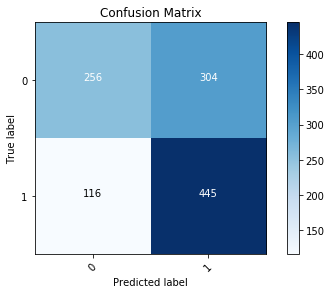

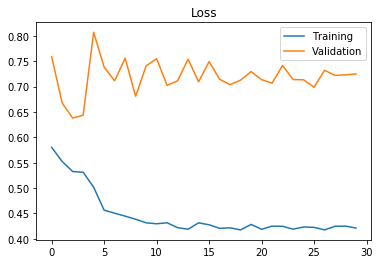

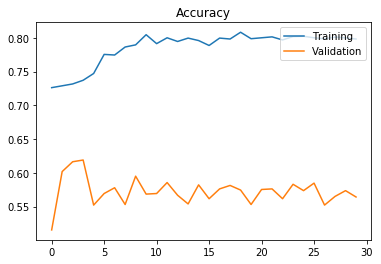

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = models.resnet18(pretrained=True)
print('model is downloaded successfully')
model.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

class_names = ['0','1']
true = []
pred = []
accuracy =0
num_epochs = 30
mymodel, train_losses, train_acc, val_losses, val_acc=train_model(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, num_epochs=num_epochs)
accuracy = test_model(mymodel, dataloader_test, criterion, optimizer, scheduler, num_epochs = 25)
plot_conf_matrix(true, pred, class_names)

### plotting ###
epochsRange = np.array(range(num_epochs))
plt.plot(epochsRange, train_losses, label='Training')
plt.plot(epochsRange, val_losses, label='Validation')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(epochsRange, train_acc, label='Training')
plt.plot(epochsRange, val_acc, label='Validation')
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [ ]:
trainset.__len__()

In [ ]:
print(2188*4)